In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


In [50]:
def mean_filter(data, number_of_points, step=1):
    
    ''' Entrada: Vetor de dados que serão filtrados = data(n,1) '''
    ''' Saída: Vetor de dados filtrados = mean_feature(n,1)'''
    mean_feature = []
    for i in range(0, number_of_points):
        mean_feature.append(np.mean(data[0: i+1]))
    if number_of_points > 1:
        for i in range(0, len(data) - number_of_points, step):
            mean_feature.append(
                np.mean(data[i: number_of_points + i]))
    else:
        return data
    return np.array(mean_feature)

In [4]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [34]:
''' Alterar o número do voluntário e a chave da repetição'''

voluntary = 1
key = 'S1_Synched'

voluntary = str(voluntary)


In [35]:
archive, name, sincro = name_data(voluntary, key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

In [36]:
data = pd.read_csv(data_path + archive, sep = ';')

### Separando os dados de aceleração para cada sensor

'Hip' 'RightUpLeg' 'LeftUpLeg' 'Head' 'Neck' 'Spine3' 'Spine2' 'Spine1' 'Spine'

In [37]:
# Separar os dados de IMU para cada sensor
Hip = data.iloc[:,0:3].values
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Head = data.iloc[:,9:12].values
Neck = data.iloc[:,12:15].values
Spine3 = data.iloc[:,15:18].values
Spine2 = data.iloc[:,18:21].values
Spine1 = data.iloc[:,21:24].values
Spine = data.iloc[:,24:27].values

In [38]:
# Definindo a frequência de amostragem
freq_amostragem = 120


''' Alterar janela do filtro '''
window_size_s = 0.1


# Definindo o número de amostras a serem filtrados
number_of_points = int(round(freq_amostragem * window_size_s))



In [39]:
# Filtrar os dados de aceleração das IMUs
RightUpLeg_mean = np.zeros(RightUpLeg.shape)
LeftUpLeg_mean = np.zeros(LeftUpLeg.shape)
Hip_mean = np.zeros(Hip.shape)
Head_mean = np.zeros(Head.shape)
Neck_mean = np.zeros(Neck.shape)
Spine3_mean = np.zeros(Spine3.shape)
Spine2_mean = np.zeros(Spine2.shape)
Spine1_mean = np.zeros(Spine1.shape)
Spine_mean = np.zeros(Spine.shape)
RightUpLeg_mean[:,0] = mean_filter(RightUpLeg[:,0], number_of_points, step=1)
RightUpLeg_mean[:,1] = mean_filter(RightUpLeg[:,1], number_of_points, step=1)
RightUpLeg_mean[:,2] = mean_filter(RightUpLeg[:,2], number_of_points, step=1)
LeftUpLeg_mean[:,0] = mean_filter(LeftUpLeg[:,0], number_of_points, step=1)
LeftUpLeg_mean[:,1] = mean_filter(LeftUpLeg[:,1], number_of_points, step=1)
LeftUpLeg_mean[:,2] = mean_filter(LeftUpLeg[:,2], number_of_points, step=1)
Hip_mean[:,0] = mean_filter(Hip[:,0], number_of_points, step=1)
Hip_mean[:,1] = mean_filter(Hip[:,1], number_of_points, step=1)
Hip_mean[:,2] = mean_filter(Hip[:,2], number_of_points, step=1)
Head_mean[:,0] = mean_filter(Head[:,0], number_of_points, step=1)
Head_mean[:,1] = mean_filter(Head[:,1], number_of_points, step=1)
Head_mean[:,2] = mean_filter(Head[:,2], number_of_points, step=1)
Neck_mean[:,0] = mean_filter(Neck[:,0], number_of_points, step=1)
Neck_mean[:,1] = mean_filter(Neck[:,1], number_of_points, step=1)
Neck_mean[:,2] = mean_filter(Neck[:,2], number_of_points, step=1)
Spine3_mean[:,0] = mean_filter(Spine3[:,0], number_of_points, step=1)
Spine3_mean[:,1] = mean_filter(Spine3[:,1], number_of_points, step=1)
Spine3_mean[:,2] = mean_filter(Spine3[:,2], number_of_points, step=1)
Spine2_mean[:,0] = mean_filter(Spine2[:,0], number_of_points, step=1)
Spine2_mean[:,1] = mean_filter(Spine2[:,1], number_of_points, step=1)
Spine2_mean[:,2] = mean_filter(Spine2[:,2], number_of_points, step=1)
Spine1_mean[:,0] = mean_filter(Spine1[:,0], number_of_points, step=1)
Spine1_mean[:,1] = mean_filter(Spine1[:,1], number_of_points, step=1)
Spine1_mean[:,2] = mean_filter(Spine1[:,2], number_of_points, step=1)
Spine_mean[:,0] = mean_filter(Spine[:,0], number_of_points, step=1)
Spine_mean[:,1] = mean_filter(Spine[:,1], number_of_points, step=1)
Spine_mean[:,2] = mean_filter(Spine[:,2], number_of_points, step=1)

In [40]:
angle_rad_hip, angle_hip = acc_to_angle(Hip)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(RightUpLeg)
angle_rad_left_up_leg, angle_left_up_leg = acc_to_angle(LeftUpLeg)
angle_rad_head, angle_head = acc_to_angle(Head)
angle_rad_neck, angle_neck = acc_to_angle(Neck)
angle_rad_spine3, angle_spine3 = acc_to_angle(Spine3)
angle_rad_spine2, angle_spine2 = acc_to_angle(Spine2)
angle_rad_spine1, angle_spine1 = acc_to_angle(Spine1)
angle_rad_spine, angle_spine = acc_to_angle(Spine)

angle_rad_hip_mean, angle_hip_mean = acc_to_angle(Hip_mean)
angle_rad_right_up_leg_mean, angle_right_up_leg_mean = acc_to_angle(RightUpLeg_mean)
angle_rad_left_up_leg_mean, angle_left_up_leg_mean = acc_to_angle(LeftUpLeg_mean)
angle_rad_head_mean, angle_head_mean = acc_to_angle(Head_mean)
angle_rad_neck_mean, angle_neck_mean = acc_to_angle(Neck_mean)
angle_rad_spine3_mean, angle_spine3_mean = acc_to_angle(Spine3_mean)
angle_rad_spine2_mean, angle_spine2_mean = acc_to_angle(Spine2_mean)
angle_rad_spine1_mean, angle_spine1_mean = acc_to_angle(Spine1_mean)
angle_rad_spine_mean, angle_spine_mean = acc_to_angle(Spine_mean)

# definindo o tempo em segundos das amostras
t_right_up_leg = np.linspace(0, len(angle_right_up_leg_mean) / freq_amostragem, len(angle_right_up_leg_mean))
t_left_up_leg = np.linspace(0, len(angle_left_up_leg_mean) / freq_amostragem, len(angle_left_up_leg_mean))
t_hip = np.linspace(0, len(angle_hip_mean) / freq_amostragem, len(angle_hip_mean))
t_head = np.linspace(0, len(angle_head_mean) / freq_amostragem, len(angle_head_mean))
t_neck = np.linspace(0, len(angle_neck_mean) / freq_amostragem, len(angle_neck_mean))
t_spine3 = np.linspace(0, len(angle_spine3_mean) / freq_amostragem, len(angle_spine3_mean))
t_spine2 = np.linspace(0, len(angle_spine2_mean) / freq_amostragem, len(angle_spine2_mean))
t_spine1 = np.linspace(0, len(angle_spine1_mean) / freq_amostragem, len(angle_spine1_mean))
t_spine = np.linspace(0, len(angle_spine_mean) / freq_amostragem, len(angle_spine_mean))

### Comparação dos dados filtrados e não filtrados

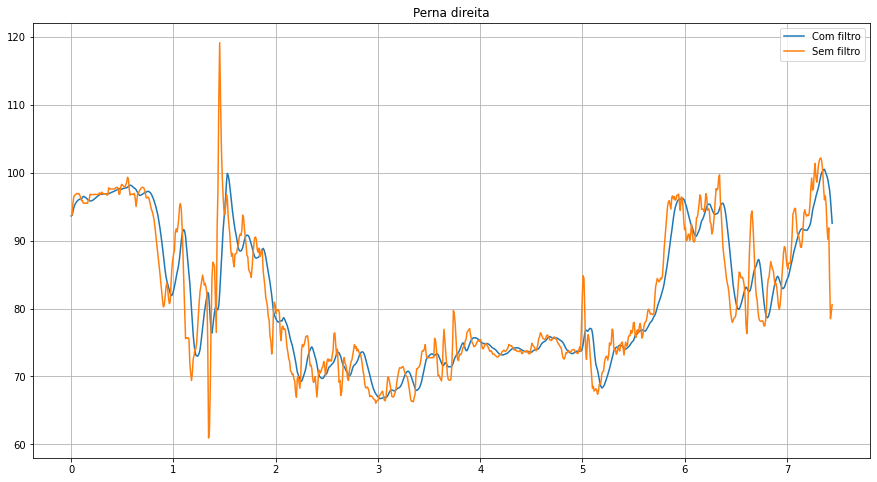

In [51]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_right_up_leg, angle_right_up_leg_mean, label = 'Com filtro')
plt.plot(t_right_up_leg, angle_right_up_leg, label = 'Sem filtro')
plt.legend()
plt.title('Perna direita')
plt.grid()
plt.show()

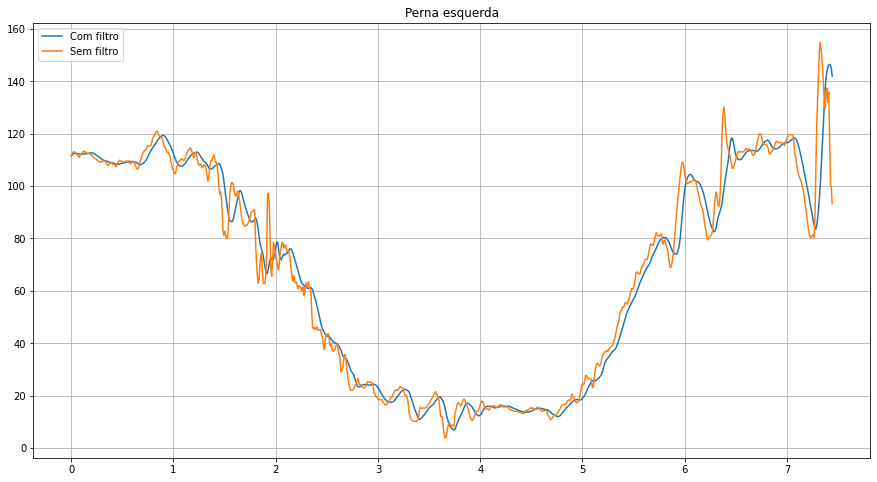

In [42]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_left_up_leg, angle_left_up_leg_mean, label = 'Com filtro')
plt.plot(t_left_up_leg, angle_left_up_leg, label = 'Sem filtro')
plt.legend()
plt.title('Perna esquerda')
plt.grid()
plt.show()

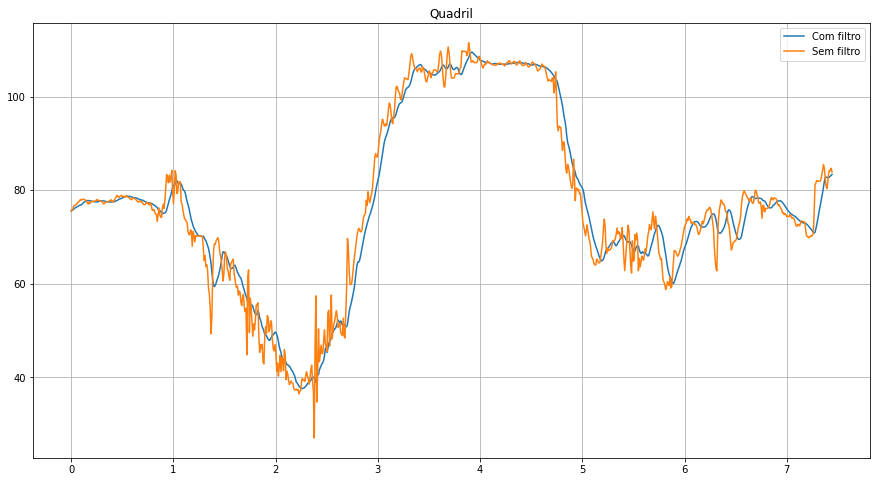

In [43]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_hip, angle_hip_mean, label = 'Com filtro')
plt.plot(t_hip, angle_hip, label = 'Sem filtro')
plt.legend()
plt.title('Quadril')
plt.grid()
plt.show()

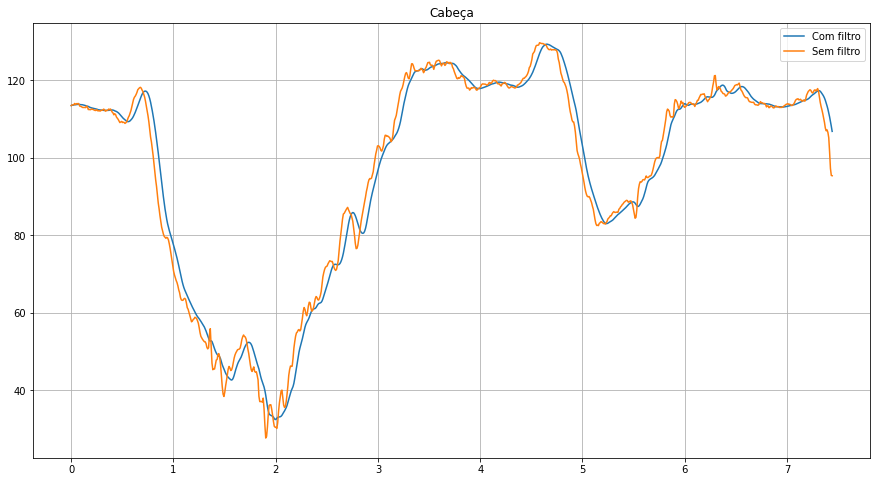

In [44]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_head, angle_head_mean, label = 'Com filtro')
plt.plot(t_head, angle_head, label = 'Sem filtro')
plt.legend()
plt.title('Cabeça')
plt.grid()
plt.show()

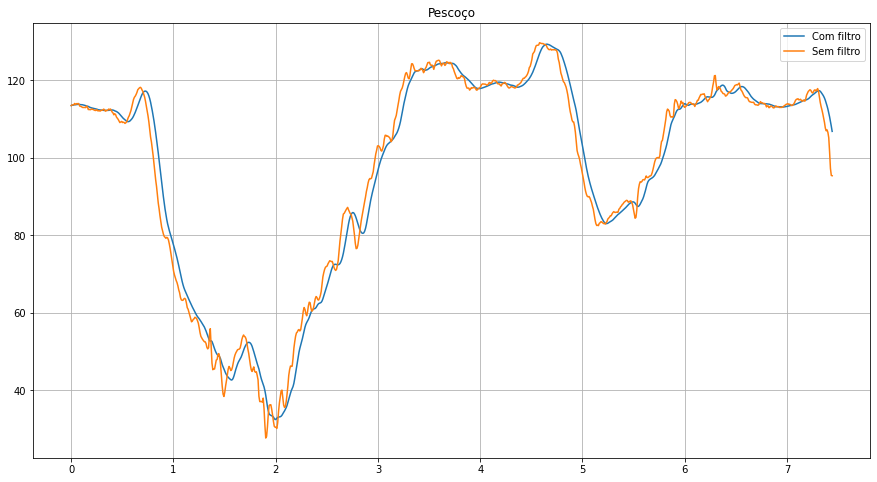

In [45]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_neck, angle_neck_mean, label = 'Com filtro')
plt.plot(t_neck, angle_neck, label = 'Sem filtro')
plt.legend()
plt.title('Pescoço')
plt.grid()
plt.show()

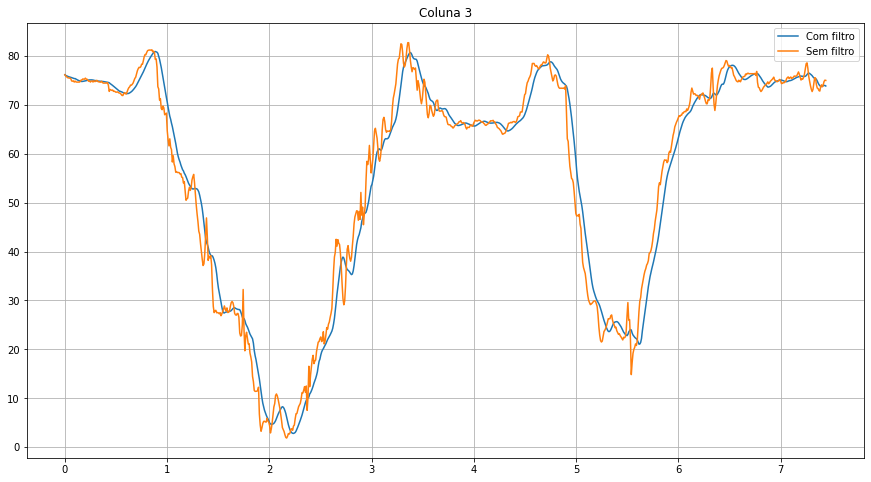

In [46]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine3, angle_spine3_mean, label = 'Com filtro')
plt.plot(t_spine3, angle_spine3, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 3')
plt.grid()
plt.show()

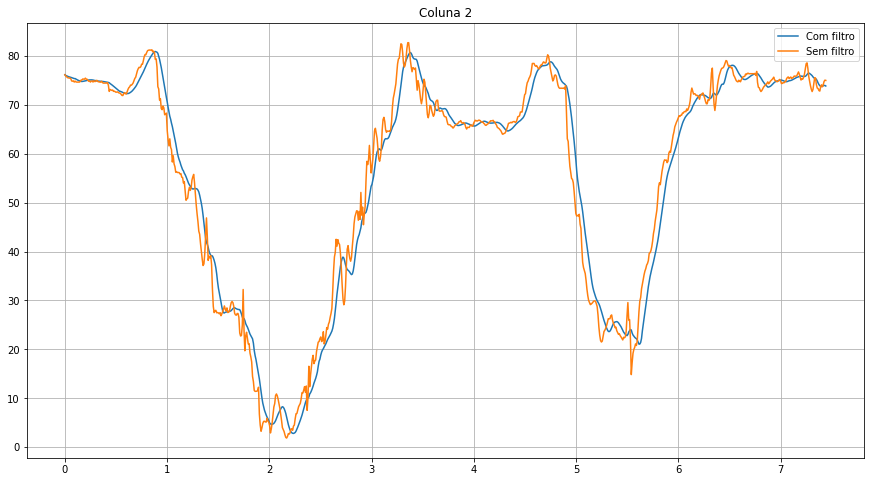

In [47]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine2, angle_spine2_mean, label = 'Com filtro')
plt.plot(t_spine2, angle_spine2, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 2')
plt.grid()
plt.show()

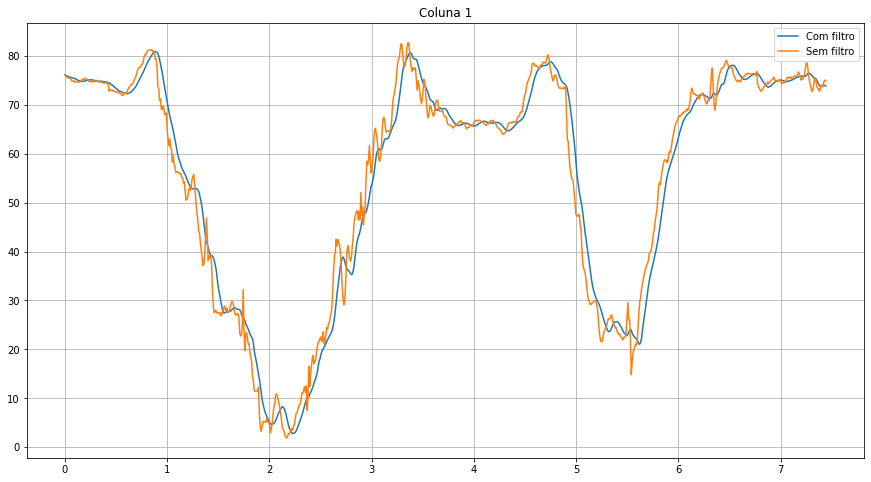

In [48]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine1, angle_spine1_mean, label = 'Com filtro')
plt.plot(t_spine1, angle_spine1, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 1')
plt.grid()
plt.show()

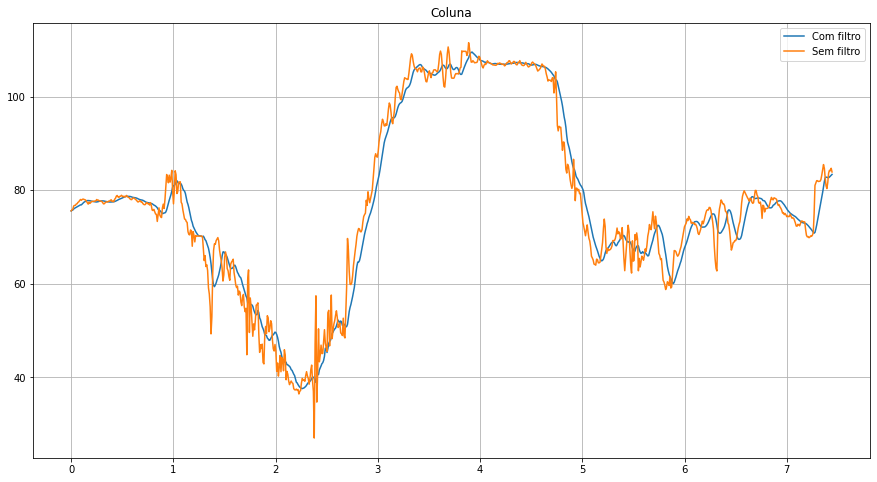

In [49]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine, angle_spine_mean, label = 'Com filtro')
plt.plot(t_spine, angle_spine, label = 'Sem filtro')
plt.legend()
plt.title('Coluna')
plt.grid()
plt.show()